Metrics for round 0: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 1.5610396), ('loss', 1.5610396), ('num_examples', 1000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Metrics for round 1: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 1.0387385), ('loss', 1.0387385), ('num_examples', 1000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Metrics for round 2: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', 0.7723317), ('loss', 0.7723317), ('num_examples', 1000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict

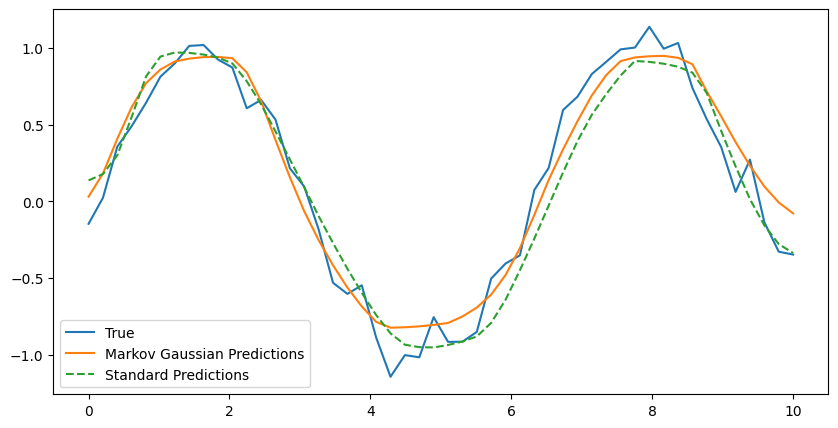

In [ ]:
# !pip install matplotlib scikit-learn
# !pip install tensorflow_federated numpy tensorflow tensorflow_probability tensorflow_addons

# !pip install --upgrade tensorflow_probability
# !pip install --upgrade tensorflow_model_optimization
# !pip install --upgrade tensorflow tensorflow-federated

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow_addons.layers import GroupNormalization
from concurrent.futures import ThreadPoolExecutor

# Markov Gaussian Updater
class MarkovGaussianUpdater:
    def __init__(self):
        self.X = []
        self.y = None
        self.gp = None

    def update_data(self, X, y):
        self.X.extend(X.flatten().tolist())
        if self.y is None:
            self.y = y.flatten().tolist()
        else:
            self.y.extend(y.flatten().tolist())

    def train_gp(self):
        if not self.X or not self.y:
            raise ValueError("Data not provided for training.")
        X_np = np.array(self.X).reshape(-1, 1).astype(np.float32)
        y_np = np.array(self.y).reshape(-1, 1).astype(np.float32)
        self.gp = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu', input_shape=(1,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            GroupNormalization(groups=8, axis=-1),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            GroupNormalization(groups=8, axis=-1),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.Dense(1)
        ])
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.gp.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
        self.gp.fit(X_np, y_np, epochs=1000, batch_size=10, verbose=0, callbacks=[early_stopping])

    def get_gp_predictions(self, X):
        if not self.gp:
            raise ValueError("Gaussian process model has not been initialized.")
        X_reshaped = tf.reshape(X, [-1, 1])
        return self.gp(X_reshaped)

# Generate synthetic data with augmentation
def generate_synthetic_data(num_samples, augment=False):
    X = np.linspace(0, 10, num_samples).astype(np.float32).reshape(-1, 1)
    y = (np.sin(X).ravel() + np.random.normal(0, 0.1, num_samples)).astype(np.float32).reshape(-1, 1)
    if augment:
        X_aug = X + np.random.normal(0, 0.1, X.shape).astype(np.float32)
        y_aug = y + np.random.normal(0, 0.1, y.shape).astype(np.float32)
        X = np.vstack((X, X_aug))
        y = np.vstack((y, y_aug))
    return X, y

# Create Keras model
def create_keras_model(updater=None):
    if updater is None:
        updater = MarkovGaussianUpdater()
        X_train, y_train = generate_synthetic_data(100, augment=True)
        updater.update_data(X_train, y_train)
        updater.train_gp()

    inputs = tf.keras.Input(shape=(1,))
    outputs = updater.get_gp_predictions(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model, updater

def create_model_fn():
    def model_fn():
        model, updater = create_keras_model()
        input_spec = {'x': tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                      'y': tf.TensorSpec(shape=[None, 1], dtype=tf.float32)}
        keras_model = tff.learning.models.from_keras_model(
            keras_model=model,
            input_spec=input_spec,
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanSquaredError()]
        )
        return keras_model
    return model_fn

def client_data_fn(client_data):
    X, y = client_data
    return tf.data.Dataset.from_tensor_slices({'x': X.astype(np.float32), 'y': y.astype(np.float32)}).batch(10)

# Ensure optimizer creation is wrapped correctly
def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

def generate_client_data(num_clients, num_samples, augment):
    with ThreadPoolExecutor() as executor:
        client_data = list(executor.map(lambda _: generate_synthetic_data(num_samples, augment), range(num_clients)))
    return client_data

# Multithreading for data generation
num_clients = 5
num_samples = 100
augment = True

clients_data = generate_client_data(num_clients, num_samples, augment)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=create_model_fn(),
    client_optimizer_fn=client_optimizer_fn
)

state = trainer.initialize()

for round_num in range(5):
    state, metrics = trainer.next(state, [client_data_fn(data) for data in clients_data])
    print(f'Metrics for round {round_num}:', metrics)

model, _ = create_keras_model()
X_test, y_test = generate_synthetic_data(50)
y_pred_markov = model.predict(X_test)
mse_markov = mean_squared_error(y_test, y_pred_markov.flatten())
print('Final MSE (Markov Gaussian):', mse_markov)

# Standard Federated Neural Network for Comparison
def create_standard_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(1,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        GroupNormalization(groups=8, axis=-1),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        GroupNormalization(groups=8, axis=-1),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(1)
    ])
    return model

def create_standard_model_fn():
    def model_fn():
        model = create_standard_keras_model()
        input_spec = {'x': tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                      'y': tf.TensorSpec(shape=[None, 1], dtype=tf.float32)}
        keras_model = tff.learning.models.from_keras_model(
            keras_model=model,
            input_spec=input_spec,
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanSquaredError()]
        )
        return keras_model
    return model_fn

standard_trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=create_standard_model_fn(),
    client_optimizer_fn=client_optimizer_fn
)

standard_state = standard_trainer.initialize()

for round_num in range(5):
    standard_state, standard_metrics = standard_trainer.next(standard_state, [client_data_fn(data) for data in clients_data])
    print(f'Standard Metrics for round {round_num}:', standard_metrics)

standard_model = create_standard_keras_model()
X_train, y_train = generate_synthetic_data(500, augment=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
standard_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
standard_model.fit(X_train, y_train, epochs=1000, batch_size=10, verbose=0, callbacks=[early_stopping])
y_pred_standard = standard_model.predict(X_test)
mse_standard = mean_squared_error(y_test, y_pred_standard.flatten())
print('Final MSE (Standard):', mse_standard)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(X_test, y_test, label='True')
plt.plot(X_test, y_pred_markov, label='Markov Gaussian Predictions')
plt.plot(X_test, y_pred_standard, label='Standard Predictions', linestyle='dashed')
plt.legend()
plt.show()